% cd /Users/willnorris/Documents/Earthlabs/SWE_Project
%matplotlib inline
import time
import os
import warnings 
import numpy as np
from numpy import newaxis 
from numpy import shape
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from netCDF4 import Dataset
from skimage.measure import block_reduce
import math

In [1]:
% cd /Users/Will/Documents/Fall_2017
%matplotlib inline
import time
import os
import warnings 
import numpy as np
from numpy import newaxis 
from numpy import shape
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from netCDF4 import Dataset
from skimage.measure import block_reduce
import math

C:\Users\Will\Documents\Fall_2017


Using TensorFlow backend.


In [2]:
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *

In [3]:
# fix random seed 
np.random.seed(7)

In [18]:
# Prep the data!
filename_19H = "all_days_19H.nc"
fid_19H = Dataset(filename_19H, "r", format = "NETCDF4")

filename = "all_days_37H.nc"
fid_37H = Dataset( filename, "r", format="NETCDF4")

tb_19H_long = fid_19H.variables['TB'][:]
tb_37H_long = fid_37H.variables['TB'][:]

tb_37H_long = block_reduce(tb_37H_long, block_size = (1,2,2), func = np.mean)

swe_long = tb_19H_long - tb_37H_long 

# choose 1 x 1 group of pixels to use 
swe_long1 = swe_long[:,50:51,110:111]

# Average the 10 x 10 group of pixels 
swe_long_avg = []
for x in range(9861):
    swe_long_avg.append(np.mean(swe_long[x,:,:]))

swe_long_avg = np.array(swe_long_avg)

time_long = pd.date_range('1/1/1990', periods =9861, freq = 'D')
data_long = pd.DataFrame(data = swe_long_avg, index = time_long)
data_long.index.name = 'Day'
data_long.columns = ['SWE (mm)']

# Forward fill the missing data points 
data_long = data_long.fillna(method = 'ffill')

C:\Users\Will\Anaconda3\envs\learning\lib\site-packages\ipykernel_launcher.py:23: UserWarning:




In [5]:
dataset = data_long[2557:].values
dataset = dataset.astype('float32')
print(np.shape(dataset))

(7304, 1)


In [6]:
# Normalize the dataset 
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [7]:
# Split into train and test sets
train_size = int(len(dataset) * .67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

4893 2411


In [8]:
# Function to make array of values into a dataset matrix
def create_dataset(dataset, look_back=360):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [9]:
# Reshape into X = t and Y = t+1
look_back = 360
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [10]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [11]:
print(np.shape(testX))

(2050, 1, 360)


In [30]:
# Create and fit the LSTM network 
model = Sequential()
model.add(LSTM(8, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=15, batch_size=1, verbose = 2)

Epoch 1/15
 - 6s - loss: 0.0017
Epoch 2/15
 - 5s - loss: 0.0015
Epoch 3/15
 - 5s - loss: 0.0015
Epoch 4/15
 - 5s - loss: 0.0014
Epoch 5/15
 - 5s - loss: 0.0014
Epoch 6/15
 - 5s - loss: 0.0014
Epoch 7/15
 - 5s - loss: 0.0014
Epoch 8/15
 - 5s - loss: 0.0014
Epoch 9/15
 - 5s - loss: 0.0014
Epoch 10/15
 - 5s - loss: 0.0014
Epoch 11/15
 - 5s - loss: 0.0014
Epoch 12/15
 - 5s - loss: 0.0014
Epoch 13/15
 - 5s - loss: 0.0014
Epoch 14/15
 - 5s - loss: 0.0014
Epoch 15/15
 - 5s - loss: 0.0014


In [31]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# Calculate  root mean square error 
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 10.79 RMSE
Test Score: 6.90 RMSE


[WinError 3] The system cannot find the path specified: '/Users/willnorris/Documents/Earthlabs/Model_Results'
C:\Users\Will\Documents\Fall_2017
Train Score: 10.79 RMSE
Test Score: 6.90 RMSE


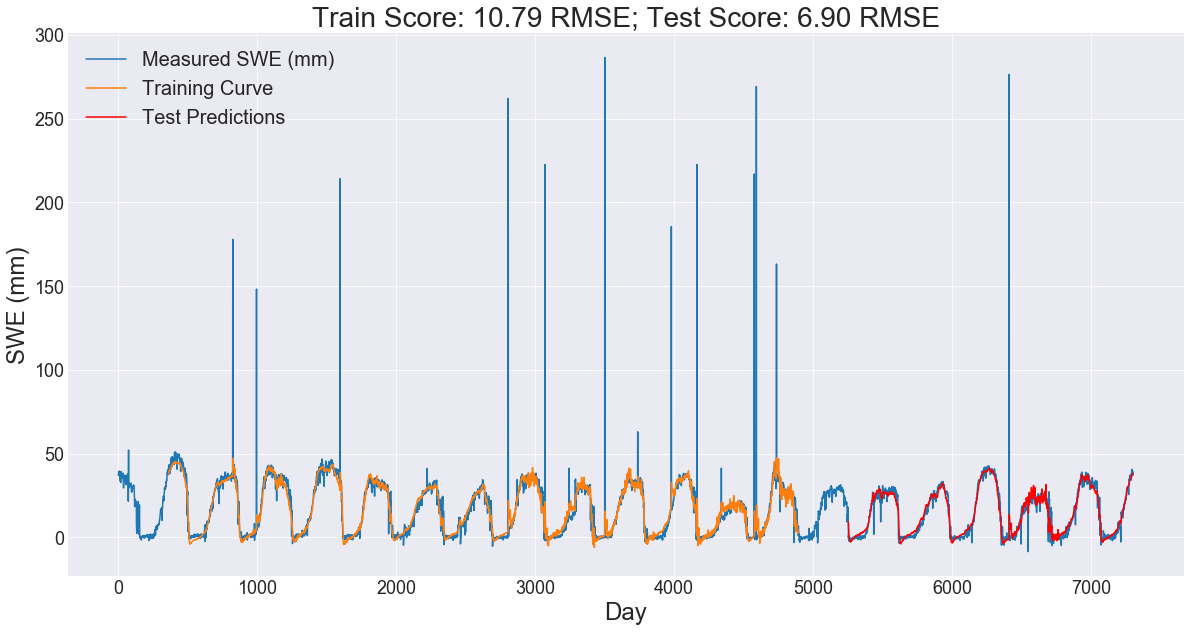

In [36]:
%cd /Users/willnorris/Documents/Earthlabs/Model_Results
# Shift train predictions for plotting
sns.set_style("darkgrid")
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
# Shift test predictions for plotting 
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back*2) + 1:len(dataset)-1, :] = testPredict
# Plot baseline and predictions 
fig, ax = plt.subplots(1,figsize = (20,10))
plt.plot(scaler.inverse_transform(dataset), label = "Measured SWE (mm)")
plt.plot(trainPredictPlot, label = "Training Curve")
plt.plot(testPredictPlot, color = "red", label = "Test Predictions")
plt.legend(fontsize = 20)
plt.ylabel('SWE (mm)', fontsize = 24)
plt.xlabel('Day', fontsize = 24)
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
#plt.legend()
plt.title('Train Score: %.2f RMSE' % (trainScore) + '; Test Score: %.2f RMSE' % (testScore), fontsize = '28')
plt.savefig('LSTM_240')
plt.show()

In [ ]:
print(np.shape(testPredict))


In [ ]:
from numpy import diff


In [ ]:
x = np.arange(2409)

In [ ]:
diff_test = np.diff(testPredictPlot.squeeze())

In [ ]:
print(diff_test)

In [ ]:
plt.plot(testPredictPlot)
plt.plot(diff_test)


In [ ]:
diff2_test = np.diff(diff_test)

In [ ]:
plt.plot(testPredictPlot)
plt.plot(diff2_test)

## Plot SWE Nicely  

In [12]:
import seaborn as sns
from matplotlib import lines

In [19]:
swe_long = np.array(swe_long)

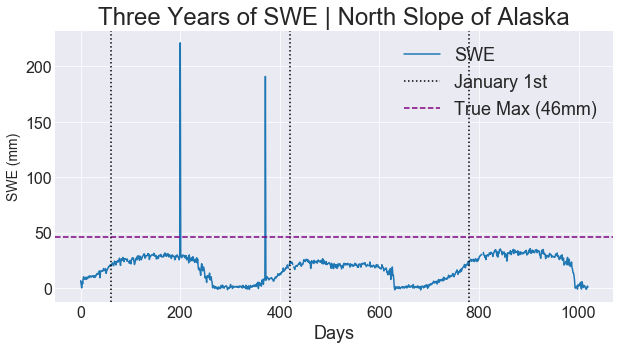

In [21]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, figsize = (10,5))
ax.plot(swe_long_avg[3180:4200], label = 'SWE')
plt.title("Three Years of SWE | North Slope of Alaska", fontsize = 24)
ax.axvline(x = 60, linestyle = ":", color = 'black', label = 'January 1st')
ax.axvline(x = 420, linestyle = ":", color = 'black')
ax.axvline(x = 780, linestyle = ":", color = 'black')
ax.axhline(y = 46, linestyle = "--", color = 'purple', label = 'True Max (46mm)')
plt.legend(loc = 1, fontsize = 18)
plt.xlabel('Days', fontsize = 18)
plt.ylabel('SWE (mm)', fontsize = 14);
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.savefig('3yrs_SWE_blog')